In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import transformers
from transformers import LayoutLMv2Processor, LayoutLMForTokenClassification, AdamW, BertForTokenClassification,\
    BertTokenizer, LayoutLMTokenizer, AutoTokenizer, AutoModelForMaskedLM, pipeline, DataCollatorForLanguageModeling
from datasets import load_dataset
import torch
from torch.nn.functional import cross_entropy
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy, copy
import seaborn as sns
import pandas as pd

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")

import re
from typing import List, Dict
    
from src.preprocessing.make_dataset import ImageLayoutDataset, PatternExploitingDataset, SplitWordsDataset
from src.model.trainer import BertTrainer, LayoutLMTrainer
import warnings
warnings.filterwarnings("ignore")

/users/eleves-a/2022/pedro.silva/few-shot-learning-transformers/.venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Importing dataset

In [3]:
dataset = load_dataset("nielsr/funsd")

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
!mkdir logs
model_name = "PET"
dataset_name = "FUNSD"
logging.basicConfig(filename=f'logs/{model_name}_{dataset_name}.log', encoding='utf-8', level= logging.INFO)

mkdir: cannot create directory ‘logs’: File exists


## Adding sequence

In [6]:
def pattern1(
    phrase : str,
    word: str,
    tokenizer
):
    return f"In the phrase '{phrase}', the {word} is in the header, in a question, or in an answer? {tokenizer.mask_token}"

In [7]:
def pattern2(
    phrase : str,
    word : str,
    tokenizer
):
    return f"In the phrase '{phrase}', is '{word}' located in the header, a question, an answer, or none ? {tokenizer.mask_token}"

### Instantiate class Dataset

In [13]:
pattern = pattern1

In [14]:
splitted_dataset = SplitWordsDataset(
    dataset['train'],
    tokenizer,
    pattern,
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 1099.73it/s]


In [15]:
validation_dataset = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 1018.78it/s]


In [254]:
splitted_dataset[0]

[{'pattern': "In the phrase 'R&D . Suggestion. Date', is 'R&D' located in the header, a question, an answer, or none ? [MASK]",
  'label': 'NONE'},
 {'pattern': "In the phrase 'R&D . Suggestion. Date', is 'Suggestion.' located in the header, a question, an answer, or none ? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase 'R&D . Suggestion. Date', is 'Date' located in the header, a question, an answer, or none ? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. . M', is 'Licensee' located in the header, a question, an answer, or none ? [MASK]",
  'label': 'ANSWER'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT SUGGESTION/ SOLUTION FORM Name / Phone Ext. . M', is 'Yes' located in the header, a question, an answer, or none ? [MASK]",
  'label': 'QUESTION'},
 {'pattern': "In the phrase ' Licensee Yes No 597005708 R&D QUALITY IMPROVEMENT 

In [32]:
first_ten = []
for i in range(10):
    first_ten.append(pd.DataFrame(splitted_dataset[i]))


In [33]:
pd.concat(first_ten)['label'].value_counts()

label
ANSWER      828
QUESTION    408
NONE        292
HEADER      112
Name: count, dtype: int64

In [16]:
device = "cuda"
model = AutoModelForMaskedLM.from_pretrained("distilbert-base-uncased")
model.to(device)

DistilBertForMaskedLM(
  (activation): GELUActivation()
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.

In [18]:
labels_idx_keymap = {
    "none": 0,
    "question" : 1,
    "answer": 2,
    "header" : 3,
}

In [19]:
device = "cuda"

model.train()
alpha = 1e-4
n_epochs = 10

optmizer = AdamW(model.parameters(), 1e-5)
history_train = []
history_val = []

n_shots = 10

for epoch in range(n_epochs):
    y_true_train = torch.tensor([],device=device)
    y_pred_train = torch.tensor([],device=device)

    for i in tqdm(range(n_shots)):

        for processed_data in (splitted_dataset[i]):
            phrase = processed_data['pattern']
            label = processed_data["label"]

            tokens = tokenizer(
                phrase,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=256
            )

            correct_word = tokenizer.tokenize(label)[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids != tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
                labels = y
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()

            logits_list = torch.tensor([
                none_logits,
                question_logits, 
                answer_logits,
                header_logits
            ])

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            predicted_value = logits_list.argmax().item()

            y_pred_train = torch.cat([
                y_pred_train, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_train = torch.cat([
                y_true_train,
                torch.tensor([real_value]).to(device)
            ])

            # logging.info(f"real value: {real_value}, predicted value : {predicted_value}")

            real_list = [0,0,0,0]
            real_list[real_value] =1

            real_list = torch.tensor(
                real_list
            )

            ce_loss = cross_entropy(
                logits_list.softmax(dim = 0).to(torch.float64),
                real_list.to(torch.float64)
            )

            mlm_loss = outputs.loss
            loss = (1-alpha)*ce_loss + mlm_loss*alpha

            loss.backward()

            optmizer.step()
            optmizer.zero_grad()

    f1 = multiclass_f1_score(
        y_pred_train,
        y_true_train,
        num_classes=4
    )
    history_train.append(f1.item())

    logging.info(f'''
                 
    -------------------------
        End of epoch {epoch} 
        F1 score : {f1}     
    ''')

    logging.info(f'''
        {multiclass_confusion_matrix(
        y_pred_train.to(torch.int64),
        y_true_train.to(torch.int64),
        num_classes=4
        )}
    ''')
    

100%|██████████| 10/10 [01:26<00:00,  8.68s/it]


Text(0.5, 1.0, '\n    Confusion matrix - Train \n    Pattern Exploited Training  \n    alpha = 0.0001  \n')

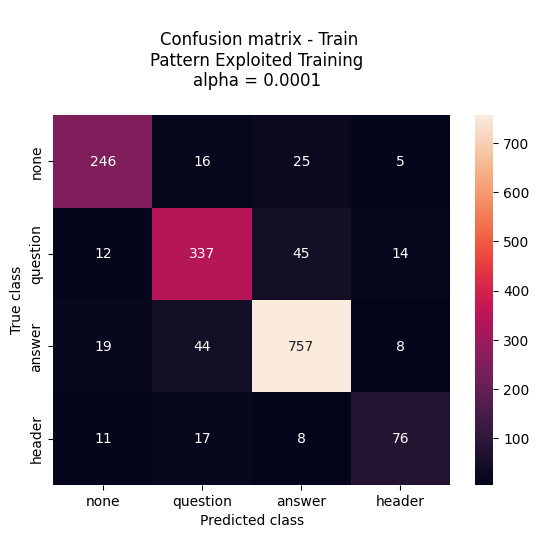

In [20]:
period = "Train"
conf_matrix = multiclass_confusion_matrix(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period} 
    Pattern Exploited Training  
    alpha = {alpha}  
''')

In [21]:
multiclass_f1_score(
    y_pred_train.to(torch.int64),
    y_true_train.to(torch.int64),
    num_classes=4
)

tensor(0.8634, device='cuda:0')

### Validation results

In [22]:
validation_dataset = SplitWordsDataset(
    dataset['test'],
    tokenizer,
    pattern,
)

100%|██████████| 50/50 [00:00<00:00, 993.30it/s]


In [26]:
y_true_val = torch.tensor([],device=device)
y_pred_val = torch.tensor([],device=device)

num_shots_validation = 50

with torch.no_grad():
    for i in tqdm(range(num_shots_validation)):

        for processed_data in (splitted_dataset[i]):

            phrase = processed_data['pattern']
            label = processed_data["label"]

            tokens = tokenizer(
                phrase,
                truncation= True,
                padding= "max_length",
                return_tensors= "pt",
                max_length=256
            )

            correct_word = tokenizer.tokenize(label)[0]

            label = tokenizer(
                correct_word,
            )

            input_ids = tokens['input_ids'].to(device)
            attention_mask = tokens['attention_mask'].to(device)

            y = input_ids.clone()

            y[input_ids== tokenizer.mask_token_id] = tokenizer.vocab[correct_word]
            y[input_ids!= tokenizer.mask_token_id] = -100

            outputs = model(
                input_ids =input_ids,
                attention_mask = attention_mask,
            )

            mask_token_index = torch.where(tokens["input_ids"] == tokenizer.mask_token_id)[1]
            mask_token_logits = outputs.logits[0, mask_token_index, :]

            question_logits = mask_token_logits[0,tokenizer.vocab["question"]].item()
            answer_logits = mask_token_logits[0, tokenizer.vocab["answer"]].item()
            header_logits = mask_token_logits[0, tokenizer.vocab["header"]].item()
            none_logits = mask_token_logits[0, tokenizer.vocab["none"]].item()

            logits = {
                "question": question_logits,
                "answer": answer_logits,
                "header": header_logits,
                "none": none_logits
            }

            predicted_value = sorted(
                logits.items(), 
                reverse= True, 
                key = lambda x: x[1]
            )[0][0]

            predicted_value = labels_idx_keymap[predicted_value]

            # logging.info(predicted_value)

            real_value = correct_word.lower()
            real_value = labels_idx_keymap[real_value]

            y_pred_val = torch.cat([
                y_pred_val, 
                torch.tensor([predicted_value]).to(device)
            ])
            
            y_true_val = torch.cat([
                y_true_val,
                torch.tensor([real_value]).to(device)
            ])

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [04:30<00:00,  5.41s/it]


Text(0.5, 1.0, '\n    Confusion matrix - Test\n    Pattern Exploited Training    \n    alpha = 0.0001\n')

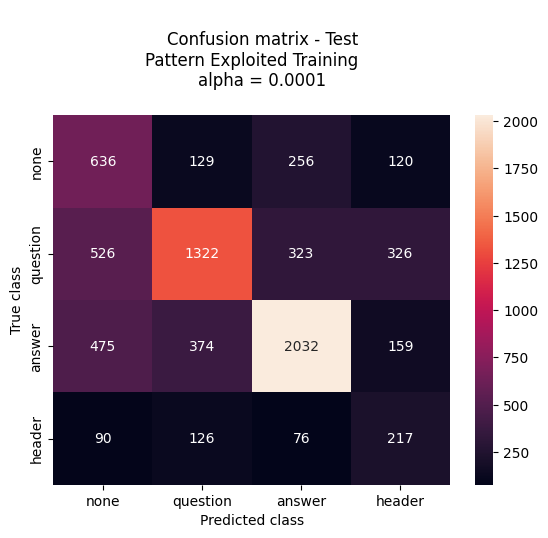

In [27]:
period = "Test"
conf_matrix = multiclass_confusion_matrix(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

confusion_df = pd.DataFrame(conf_matrix.cpu().numpy())


confusion_df = confusion_df\
    .rename(columns={v:k for k, v in labels_idx_keymap.items()})\
    .rename(index = {v:k for k, v in labels_idx_keymap.items()})

sns.heatmap(confusion_df,
            annot= True,
            fmt = ".0f")

plt.ylabel("True class")
plt.xlabel("Predicted class")

plt.title(f'''
    Confusion matrix - {period}
    Pattern Exploited Training    
    alpha = {alpha}
''')

In [28]:
multiclass_f1_score(
    y_pred_val.to(torch.int64),
    y_true_val.to(torch.int64),
    num_classes=4
)

tensor(0.5854, device='cuda:0')

In [34]:
first_ten = []
for i in range(50):
    first_ten.append(pd.DataFrame(validation_dataset[i]))

pd.concat(first_ten)['label'].value_counts()

label
ANSWER      3038
QUESTION    2543
NONE        2306
HEADER       372
Name: count, dtype: int64